# Quantum walks on one and two dimentional lattice

In this tutorial, we implement 1D and 2D quantum walk.　

Quantum walks are quantum-mechanical extensions of classical random walks and play a central role in the design of quantum algorithms. In particular, quantum walks are known to provide polynomial, and in some cases exponential, speedups over classical methods for tasks such as search problems and the acceleration of Markov-chain–based procedures.

There are two main types of quantum walks: discrete-time quantum walks and continuous-time quantum walks. In the discrete-time model, the time evolution is defined by a unitary operator $U = S(C \otimes I)$, where $C$ is a coin operator and $S$ is a shift operator. In the continuous-time model, the adjacency matrix $A$ or the Laplacian $L$ of the graph is used as the Hamiltonian, and the state evolves according to the unitary operator $e^{-iHt}$.

Unlike classical random walks, quantum walks exhibit dramatically different behavior due to interference and unitarity. For instance, the probability distribution does not take a Gaussian form; instead, it spreads ballistically, leading to an $O(t)$ dispersion rather than the classical $O(\sqrt{t})$. These properties form the foundation for the speedups observed in quantum-walk–based algorithms.

Quantum walks have a wide range of applications, including search algorithms, Hamiltonian simulation, quantum Markov chains, and quantum machine learning. In particular, Szegedy’s quantum walk provides a general framework for quantizing classical Markov chains into unitary operators, enabling powerful algorithmic constructions across diverse domains.



## 1D Quantum Walk

In a one-dimensional discrete-time quantum walk, the position space is the integer lattice $\mathbb{Z}$, and the coin space is a two-dimensional Hilbert space. The state is written as

$$
|\psi_t\rangle = \sum_{x=0}^{N-1}\sum_{l=0}^{1} \alpha_{x,l}|x\rangle \otimes|l\rangle .
$$

Using a coin operator $C$ and a shift operator $S$, one step of the time evolution is defined by

$$
U = S(C \otimes I).
$$

A typical example of a coin is the Hadamard coin:

$$
C = H = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}.
$$

The shift operator moves the walker left or right depending on the coin state:

$$
S|x\rangle|0\rangle = |x-1\rangle|0\rangle,\qquad
S|x\rangle|1\rangle = |x+1\rangle|1\rangle.
$$

As a result, the quantum walk spreads ballistically due to interference, producing a probability distribution very different from the Gaussian diffusion of classical random walks.




In [1]:
import matplotlib.pyplot as plt
import numpy as np

from classiq import *

In [2]:
# n is number of qubits
n = 6
# number of grids of 1 dimentional lattice
circle_size = 2**n
NUM_SAMPLES = 1000

In [3]:
@qfunc
def coin_opeator(C: QNum):
    hadamard_transform(C)


@qfunc
def shift_right(x: QNum):
    x += 1


@qfunc
def shift_left(x: QNum):
    x += -1


@qfunc
def shift_opeartor(x: QNum, C: QNum):
    control(C == 1, lambda: shift_right(x))
    control(C == 0, lambda: shift_left(x))


@qfunc
def quantum_walk(x: QNum, C: QNum):
    coin_opeator(C)
    shift_opeartor(x, C)


@qfunc
def coin_walk(t: CInt, x: QNum, C: QNum):
    power(
        t,
        lambda: quantum_walk(x, C),
    )


@qfunc
def super_position(C: QNum):  # 1/sqrt(2)[1, 1j]
    H(C)
    S(C)
    # X(C)


@qfunc
def initial_state(x: QNum, C: QNum):
    x ^= circle_size // 2
    super_position(C)


@qfunc
def main(t: CInt, x: Output[QNum]):
    C = QNum("C")
    allocate(n, x)
    allocate(1, C)
    initial_state(x, C)
    coin_walk(t, x, C)
    # to avoid warning
    drop(C)

In [4]:
qmod = create_model(
    main, execution_preferences=ExecutionPreferences(num_shots=NUM_SAMPLES)
)
write_qmod(qmod, decimal_precision=15, name="1d_quantumwalk")
qprog_1d = synthesize(qmod)
show(qprog_1d)

Quantum program link: https://platform.classiq.io/circuit/36pbWzE4KinG59Sag2aIt5QsPiG


In [5]:
with ExecutionSession(qprog_1d) as es:
    result = es.sample({"t": 1})

Text(0, 0.5, 'probability')

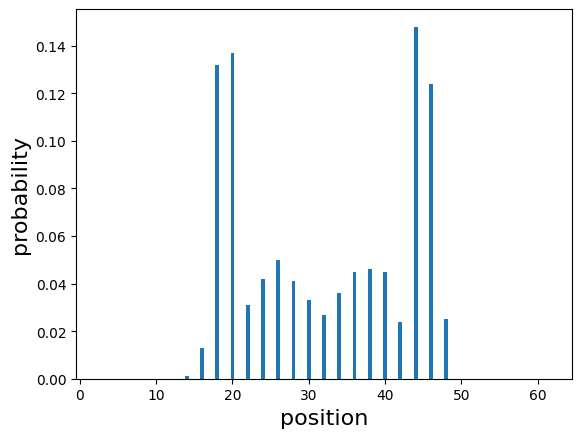

In [6]:
with ExecutionSession(qprog_1d) as es:
    result = es.sample({"t": 20})


# quantum
quantum_probs = {
    sample.state["x"]: sample.shots / NUM_SAMPLES for sample in result.parsed_counts
}
sorted_quantum_probs = dict(sorted(quantum_probs.items()))


plt.bar(sorted_quantum_probs.keys(), sorted_quantum_probs.values(), width=0.5)
plt.xlim(-0.5, circle_size + 0.5)
plt.xlabel("position", fontsize=16)
plt.ylabel("probability", fontsize=16)

## 2 dimentional quantum walk

In a discrete-time quantum walk on a two-dimensional lattice, the position space is $\mathbb{Z}^2$, and a four-dimensional coin space is used to represent movement directions. The state is written as

$$
|\psi_t\rangle = \sum_{x=0}^{N-1}\sum_{y=0}^{N-1} \sum_{l=0}^{3} \alpha_t(x,y,l) |x,y\rangle \otimes |l\rangle.
$$

The coin operator $C$ is a $4 \times 4$ unitary matrix. A commonly used example is the Grover coin:

$$
C = G_4 = \frac{1}{2}
\begin{pmatrix}
-1 & 1 & 1 & 1 \\
1 & -1 & 1 & 1 \\
1 & 1 & -1 & 1 \\
1 & 1 & 1 & -1
\end{pmatrix}.
$$

The shift operator $S$ moves the walker according to the coin state:

$$
\begin{aligned}
S|x,y\rangle|0\rangle &= |x+1,y\rangle|0\rangle,\\
S|x,y\rangle|1\rangle &= |x-1,y\rangle|1\rangle,\\
S|x,y\rangle|2\rangle &= |x,y+1\rangle|2\rangle,\\
S|x,y\rangle|3\rangle &= |x,y-1\rangle|3\rangle.
\end{aligned}
$$

The time evolution is given, as in the 1D case, by

$$
U = S(C \otimes I).
$$

Two-dimensional quantum walks exhibit richer interference patterns, and it is known that strong localization can occur, particularly when using the Grover coin.

In [7]:
n = 5
circle_size = 2**n
NUM_SAMPLES = 1000

In [8]:
@qfunc
def coin_opeator(C: QNum):
    # hadamard_transform(C)
    grover_diffuser(lambda i: hadamard_transform(i), C)


@qfunc
def shift_plus(pos: QNum):
    pos += 1


@qfunc
def shift_minus(pos: QNum):
    pos += -1


@qfunc
def shift_opeartor(x: QNum, y: QNum, C: QNum):
    control(C == 0, lambda: shift_plus(x))
    control(C == 1, lambda: shift_minus(x))
    control(C == 2, lambda: shift_plus(y))
    control(C == 3, lambda: shift_minus(y))


@qfunc
def quantum_walk(x: QNum, y: QNum, C: QNum):
    coin_opeator(C)
    shift_opeartor(x, y, C)


@qfunc
def coin_walk(t: CInt, x: QNum, y: QNum, C: QNum):
    power(
        t,
        lambda: quantum_walk(x, y, C),
    )


@qfunc
def main(t: CInt, x: Output[QNum], y: Output[QNum]):
    C = QNum("C")
    allocate(n, x)
    allocate(n, y)
    # initial state
    x ^= circle_size // 2
    y ^= circle_size // 2
    prepare_amplitudes([1 / 2, 1 / 2, -1 / 2, -1 / 2], 0.0, C)
    coin_walk(t, x, y, C)
    drop(C)

In [9]:
qmod = create_model(
    main, execution_preferences=ExecutionPreferences(num_shots=NUM_SAMPLES)
)
write_qmod(qmod, decimal_precision=15, name="2d_quantumwalk")
qprog_2d = synthesize(qmod)
show(qprog_2d)

Quantum program link: https://platform.classiq.io/circuit/36pbYSrYqQHQjfPUsLSauntyXAq


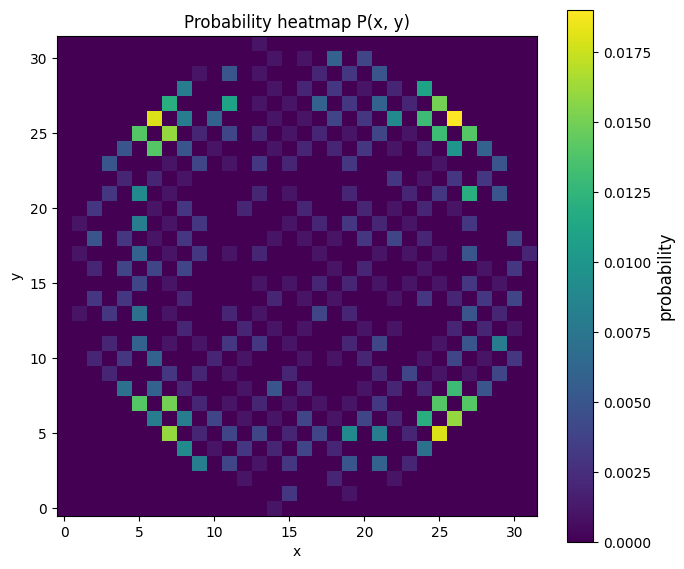

In [10]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

with ExecutionSession(qprog_2d) as es:
    result = es.sample({"t": 20})

quantum_probs = {
    (s.state["x"], s.state["y"]): s.shots / result.num_shots
    for s in result.parsed_counts
}


"""
Data Vizualization
"""
L = 1 << n


Z = np.zeros((L, L), dtype=float)
for (x, y), p in quantum_probs.items():
    if 0 <= x < L and 0 <= y < L:
        Z[y, x] = p

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(
    Z,
    origin="lower",
    extent=[-0.5, L - 0.5, -0.5, L - 0.5],
    aspect="equal",
    interpolation="nearest",
    vmin=0.0,
    vmax=Z.max() if Z.max() > 0 else 1.0,
)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("probability", fontsize=12)

ax.set_xlim(-0.5, L - 0.5)
ax.set_ylim(-0.5, L - 0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Probability heatmap P(x, y)")
plt.tight_layout()
plt.show()